Source code for paper: Denoised Labels for Financial Time-Series Data via Self-Supervised Learning

url: https://arxiv.org/abs/2112.10139

Please email me if you have any question. 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set_style(style="whitegrid") 
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import yfinance as yf
from tensorflow.keras.layers import Input, Conv1D,Conv1DTranspose
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import model_from_json
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="1"  

## import dataset

In [3]:
df=yf.download('^GSPC',start='2016-10-21',end='2019-1-1')
df = df[['Adj Close']]
df.rename(columns = {'Adj Close':'price'}, inplace = True)
for i in range(2,52):
    df['SMA{}'.format(i)] = 0
    df['SMA{}'.format(i)] = df[['price']].rolling(window=i).mean()
    
df=df.dropna()
for i in range(2,52):
    df['EMA{}'.format(i)] = 0
    df['EMA{}'.format(i)] = df[['price']].ewm(span=i, adjust=False).mean()
df

[*********************100%***********************]  1 of 1 completed


,price,SMA2,SMA3,SMA4,SMA5,SMA6,SMA7,SMA8,SMA9,SMA10,...,EMA42,EMA43,EMA44,EMA45,EMA46,EMA47,EMA48,EMA49,EMA50,EMA51
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2257.830078,2248.330078,2248.640055,2248.960022,2252.943994,2254.751668,2255.638567,2256.831238,2258.378879,2258.793994,...,2257.830078,2257.830078,2257.830078,2257.830078,2257.830078,2257.830078,2257.830078,2257.830078,2257.830078,2257.830078
2017-01-04,2270.750000,2264.290039,2255.803385,2254.167542,2253.318018,2255.911662,2257.037144,2257.527496,2258.377767,2259.615991,...,2258.431005,2258.417347,2258.404297,2258.391814,2258.379862,2258.368408,2258.357422,2258.346875,2258.336742,2258.326998
2017-01-05,2269.000000,2269.875000,2265.860026,2259.102539,2257.134033,2255.931681,2257.781424,2258.532501,2258.802219,2259.439990,...,2258.922586,2258.898377,2258.875217,2258.853039,2258.831783,2258.811391,2258.791813,2258.773000,2258.754909,2258.737498
2017-01-06,2276.979980,2272.989990,2272.243327,2268.640015,2262.678027,2260.441691,2258.938581,2260.181244,2260.582221,2260.619995,...,2259.762465,2259.720268,2259.679873,2259.641167,2259.604047,2259.568416,2259.534187,2259.501279,2259.469617,2259.439132
2017-01-09,2268.899902,2272.939941,2271.626628,2271.407471,2268.691992,2263.715007,2261.650007,2260.183746,2261.149984,2261.413989,...,2260.187462,2260.137524,2260.089652,2260.043721,2259.999615,2259.957228,2259.916461,2259.877224,2259.839433,2259.803008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2351.100098,2383.860107,2411.713379,2435.525024,2457.652002,2472.366659,2490.592843,2510.586243,2526.195557,2537.254004,...,2655.227998,2657.541336,2659.794054,2661.987990,2664.124876,2666.206353,2668.233977,2670.209232,2672.133539,2674.008255
2018-12-26,2467.699951,2409.400024,2411.806722,2425.710022,2441.960010,2459.326660,2471.699986,2487.731232,2505.821099,2520.345996,...,2646.505764,2648.912182,2651.256538,2653.540684,2655.766369,2657.935253,2660.048914,2662.108861,2664.116535,2666.073321
2018-12-27,2488.830078,2478.265015,2435.876709,2431.062561,2438.334033,2449.771688,2463.541434,2473.841248,2487.853326,2504.121997,...,2639.172011,2641.635723,2644.037584,2646.379353,2648.662697,2650.889204,2653.060391,2655.177710,2657.242556,2659.256273


## noisy input and pure input

In [4]:
from sklearn.model_selection import train_test_split


X = df[['price']].values
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

# noisy set
num_samples = len(df.columns)-1
total_num_elements = len(X)


samples = []
xs = []
ys = []
for j in range(0, num_samples):
    for i in range(0, total_num_elements):
        x = i 
        y = X[i] 
        xs.append(x)
        ys.append(y)
    samples.append((xs, ys))
    xs = []
    ys = []

# Reshape data
data_noisy = np.array(samples)
x_val_noisy, y_val_noisy = data_noisy[:,0], data_noisy[:,1] 
noisy = y_val_noisy.reshape((y_val_noisy.shape[0], y_val_noisy.shape[1], 1))
print(noisy.shape)

noisy = np.asarray(noisy).astype('float32')
noisy_input,noisy_input_test = train_test_split(noisy,test_size=0.2, random_state=1,shuffle=False)
noisy_input = np.asarray(noisy_input).astype('float32')
noisy_input_test = np.asarray(noisy_input_test).astype('float32')

# pure set
df3 = df.drop('price', 1)
pure_set = df3.values
scaler_pure = MinMaxScaler()
pure_set = scaler_pure.fit_transform(pure_set)

pure_transform = pure_set.T
pure_samples = []
xs = []
ys = []

for j in range(0,num_samples):
    for i in range (0,len(X)):
        x = i
        y = pure_transform[j,i]
        xs.append(x)
        ys.append(y)
    pure_samples.append((xs, ys))
    xs = []
    ys = []
    
# Reshape data
data_pure = np.array(pure_samples)
x_val_pure, y_val_pure = data_pure[:,0], data_pure[:,1]
pure = y_val_pure.reshape((y_val_pure.shape[0], y_val_pure.shape[1], 1))
print(pure.shape)

pure_input,pure_input_test = train_test_split(pure,test_size=0.2, random_state=1,shuffle=False)
pure_input = np.asarray(pure_input).astype('float32')
pure_input_test = np.asarray(pure_input_test).astype('float32')

(100, 502, 1)
(100, 502, 1)


In [24]:
pure_set

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02340582, 0.01056606, 0.00771624, ..., 0.00083467, 0.00081959,
        0.00080509],
       [0.03159636, 0.02539981, 0.01502868, ..., 0.00152291, 0.00149603,
        0.00147017],
       ...,
       [0.33720739, 0.27617792, 0.26983051, ..., 0.64175319, 0.64609878,
        0.65037505],
       [0.35043556, 0.3423768 , 0.29543511, ..., 0.63080688, 0.63521931,
        0.63956258],
       [0.36364904, 0.36162589, 0.35313076, ..., 0.62166222, 0.62610563,
        0.63048142]])

## denoising autoencoder

In [5]:
input_shape = (len(X), 1)
batch_size = 10
no_epochs = 20
train_test_split = 0.3
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0

In [6]:
# Create the model
# create a loop if you want to repeat it multiple times
autoencoder = Sequential()
autoencoder.add(Conv1D(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
autoencoder.add(Conv1D(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
autoencoder.add(Conv1DTranspose(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
autoencoder.add(Conv1DTranspose(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
autoencoder.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

autoencoder.summary()

# Compile and fit data
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_train = autoencoder.fit(noisy_input, pure_input,
                    epochs=no_epochs,
                    batch_size=batch_size,
                    validation_data=(noisy_input_test,pure_input_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 128)          512       
                                                                 
 conv1d_1 (Conv1D)           (None, 498, 32)           12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 500, 32)          3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 502, 128)         12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, 502, 1)            385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

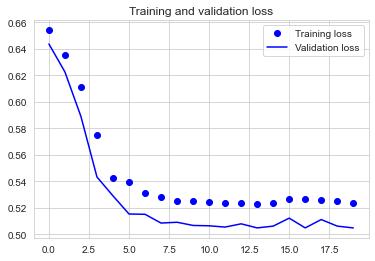

In [7]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
no_epochs = range(no_epochs)
plt.figure()
plt.plot(no_epochs, loss, 'bo', label='Training loss')
plt.plot(no_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
# Generate reconstructions
samples = noisy_input_test[:1]
reconstructions = autoencoder.predict(samples)
e=np.array(reconstructions[0]) #reconstrcuted prices
X_inverse = scaler_X.inverse_transform(X)
e_inverse = scaler_X.inverse_transform(e)

1/1 [==============================] - 0s 134ms/step


In [31]:
reconstructions.shape


(1, 502, 1)

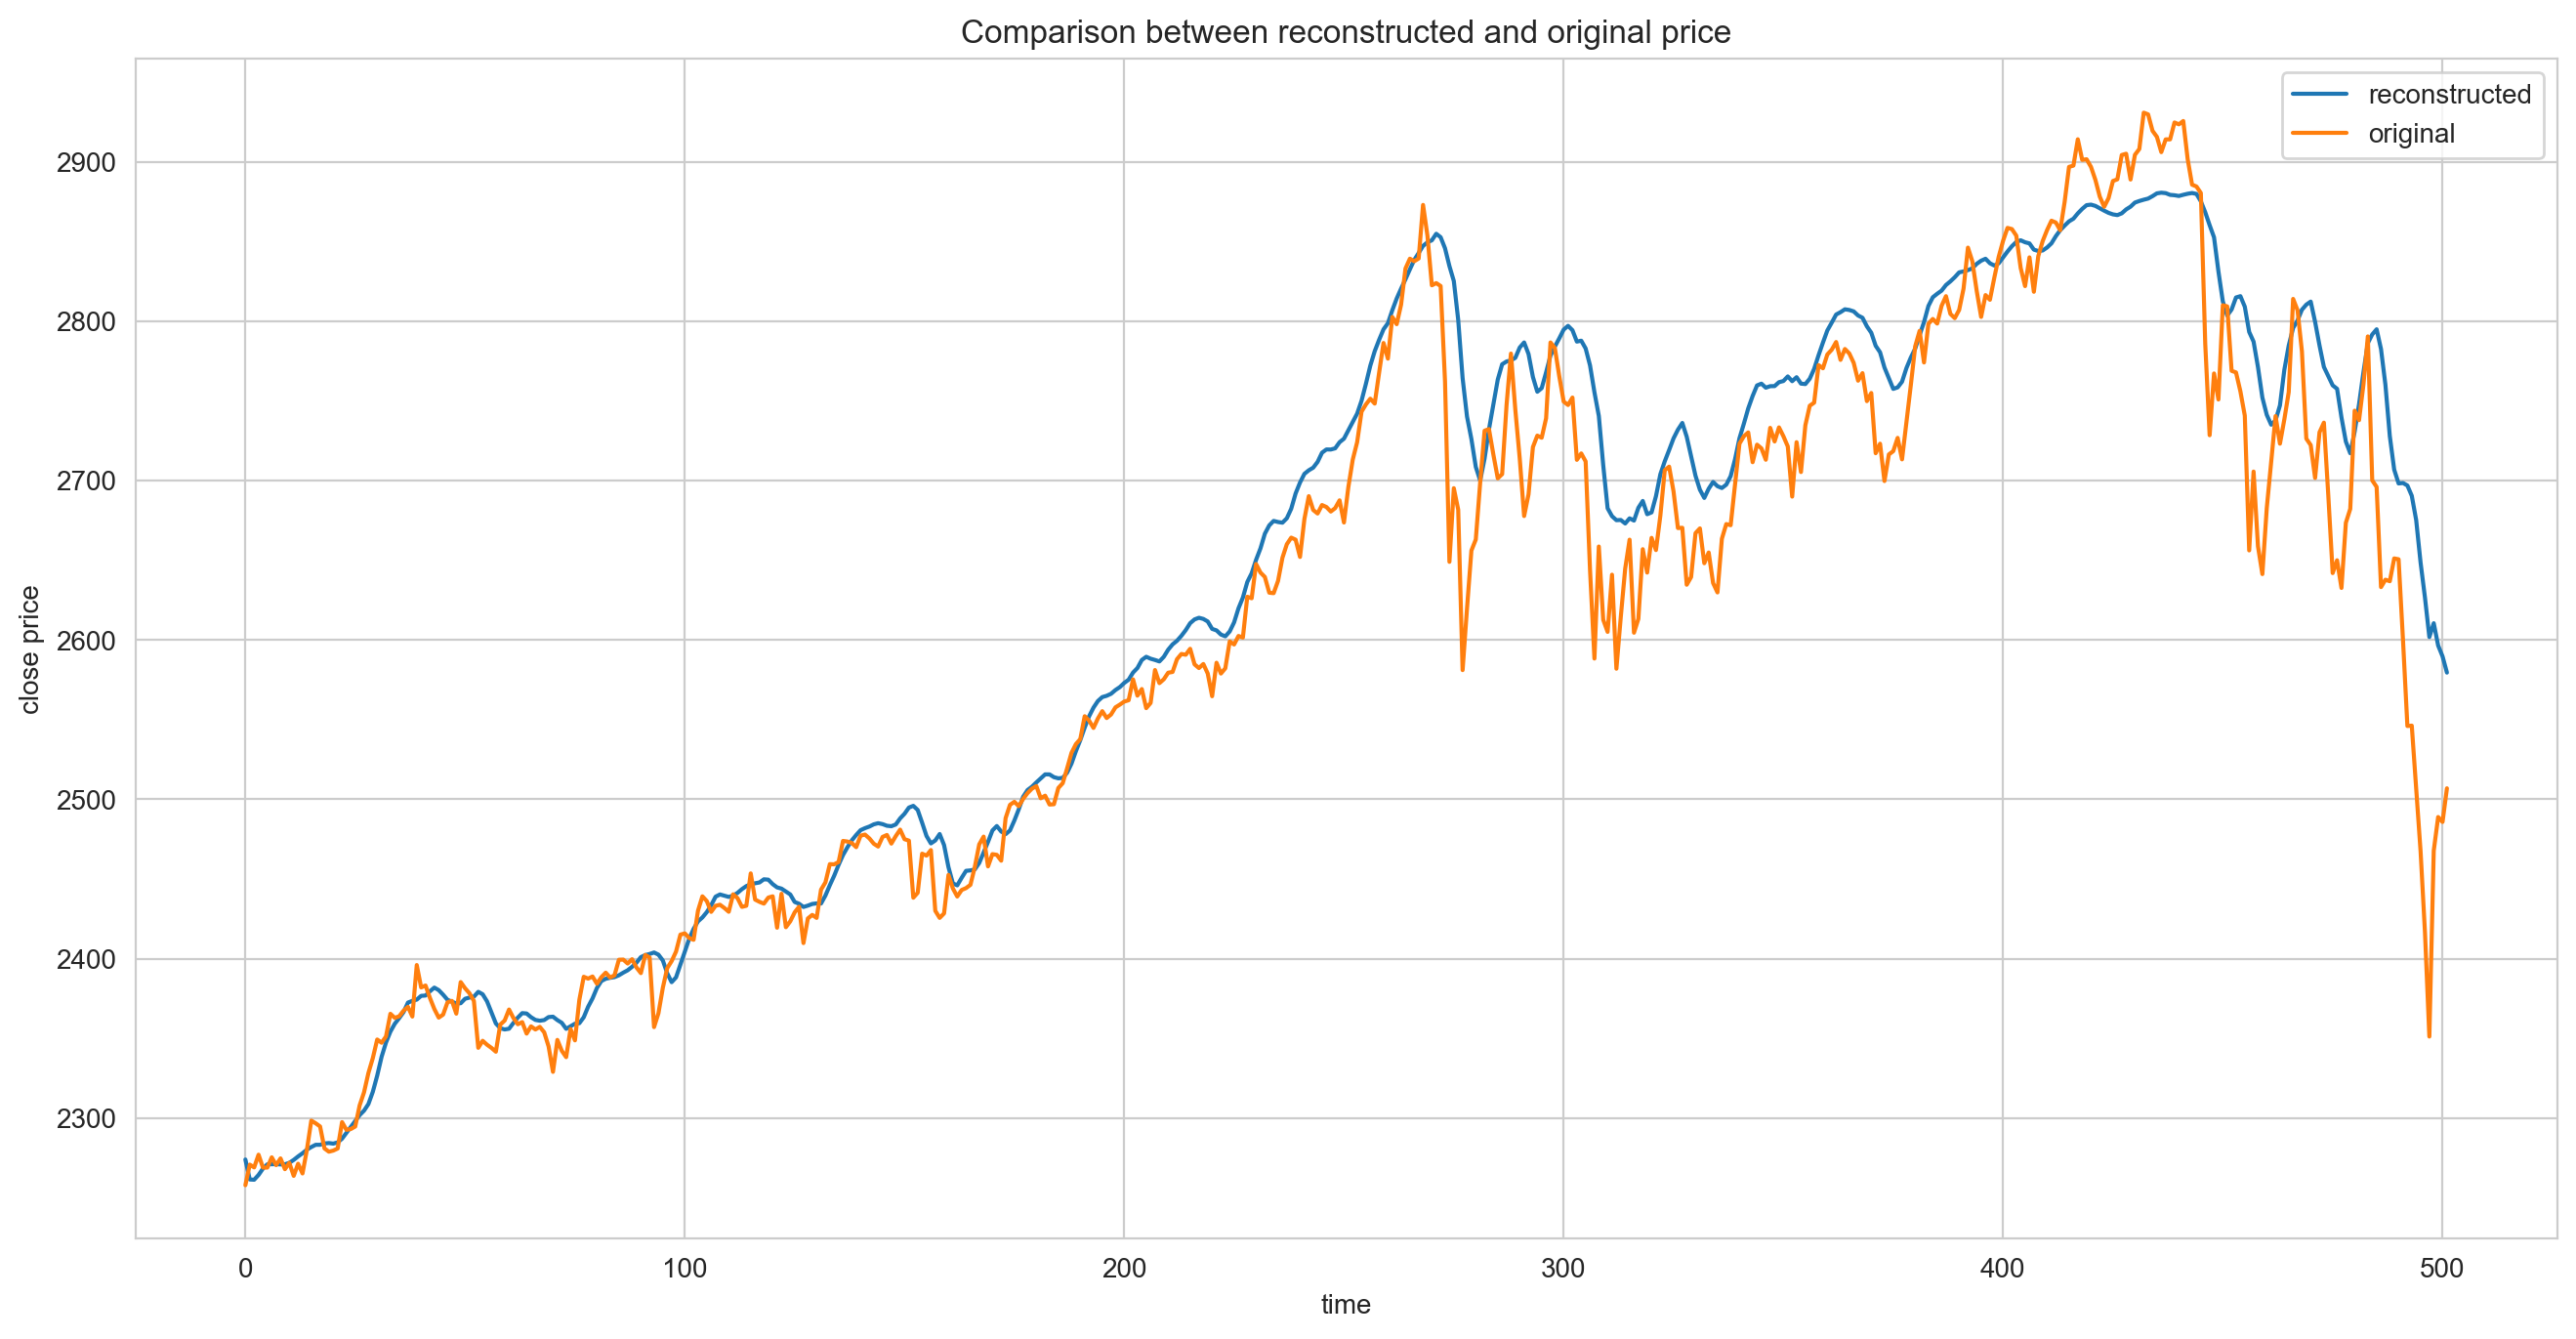

In [33]:
plt.figure(figsize=(16,8),dpi=200)
plt.plot(e_inverse,label='reconstructed')
plt.plot(X_inverse,label='original')
plt.plot()
plt.ylabel('close price')
plt.xlabel('time')
plt.title('Comparison between reconstructed and original price')
plt.legend()

## downstream task: SVM

In [10]:
# svm
df4 = df[['price']]
signal_list = np.arange(0,0.35,0.0005) #threshold of log-returns
percentage = int(0.8*len(df4)) #splitting training and testing sets

#reconstructed x
x_train_encode = e[:percentage]
x_train_encode = x_train_encode.reshape(-1,1)
x_test_encode = e[percentage:]
x_test_encode = x_test_encode.reshape(-1,1)
r = [np.log(e[l]/e[l-1]) for l in range(1,len(e))]
r = np.insert(r,0,0)
print(x_train_encode.shape,x_test_encode.shape)

#original x
x_train = X[:percentage]
x_test = X[percentage:]
Returns = [np.log(X[l]/X[l-1]) for l in range(1,len(X))]
Returns = np.insert(Returns,0,0)
print(x_train.shape,x_test.shape)

(401, 1) (101, 1)
(401, 1) (101, 1)


In [42]:
# f1 for original prices
sl = []

for i in signal_list:
    f1 = 0
    y = np.zeros_like(Returns)
    for n in range(len(Returns)):
        if Returns[n] < -i:
            y[n] = -1
        elif Returns[n] > i:
            y[n] = 1
        else:
            y[n] = 0

    y_train = y[:percentage]
    y_test = y[percentage:]

#   clf = SVC(C=0.8, class_weight=None, decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf')
    clf = SVC()
    model = clf.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test,y_pred,average='weighted')

    sl.append(f1)
# print(sl)

In [43]:
# f1 for reconstructed prices
sl_1 = []

for i in signal_list:
    f1=0
    
    y = np.zeros_like(Returns)
    for n in range(len(Returns)):
        if Returns[n] < -i:
            y[n] = -1
        elif Returns[n] > i:
            y[n] = 1
        else:
            y[n] = 0

    y_train = y[:percentage]
    y_test = y[percentage:]
    
    y1 = np.zeros_like(r)
    for n in range(len(r)):
        if r[n] < -i:
            y1[n] = -1
        elif r[n] > i:
            y1[n] = 1
        else:
            y1[n] = 0 
        
    y_train_encode = y1[:percentage]
    y_test_encode = y1[percentage:]   
    
    clf = SVC()
#     clf = SVC(C=0.8, class_weight=None, decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf')
    model1 = clf.fit(x_train_encode,y_train_encode)
    y_pred1 = model1.predict(x_test_encode)
    f1 = f1_score(y_test_encode,y_pred1,average='weighted')
    sl_1.append(f1)
# print(sl_1)

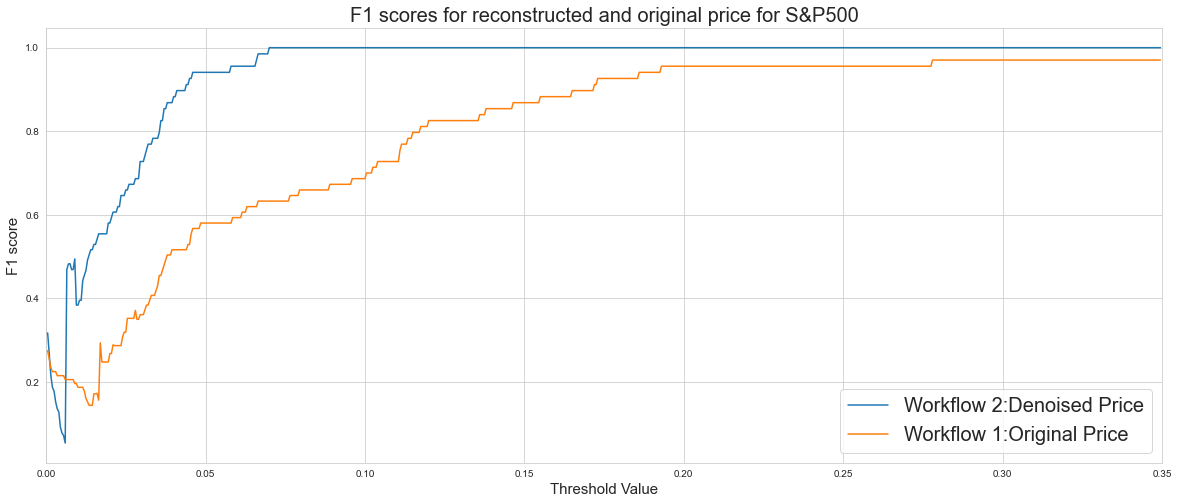

In [44]:
plt.figure(figsize=(20,8))
plt.xlim(0,0.35)
plt.ylabel('F1 score',fontsize=15)
plt.xlabel('Threshold Value',fontsize=15)
plt.title('F1 scores for reconstructed and original price for S&P500',fontsize=20)
plt.plot(signal_list,sl_1,label='Workflow 2:Denoised Price')
plt.plot(signal_list,sl,label='Workflow 1:Original Price')
plt.rcParams["figure.figsize"] = (20,8)
plt.legend(loc=4, prop={'size': 20})

In [14]:
# save the data as pandas form
df_original = pd.DataFrame(X_inverse,columns=['original_price'],index=df.index)
df_encode = pd.DataFrame(e_inverse,columns=['autoencoder_price'],index=df.index)
# print(df_original.shape,df_encode.shape)
# print(df_encode)

## trading indicators

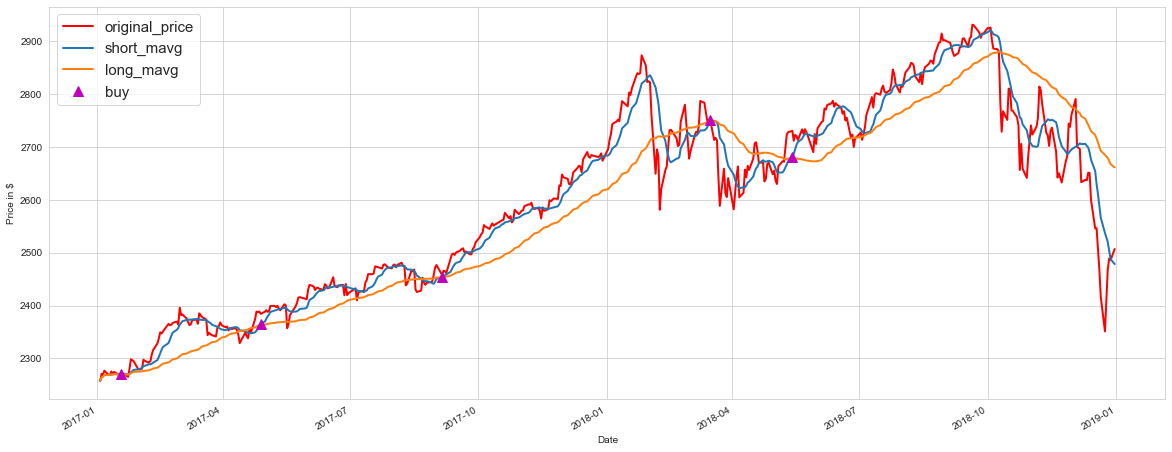

In [15]:
############ moving average cross over
## original 
short_window = 10
long_window = 50

# Initialize the `signals` DataFrame with the `signal` column
trade_signals = pd.DataFrame(index=df_original.index)
trade_signals['trade_signal'] = 0.0

# Create short simple moving average over the short window
trade_signals['short_mavg'] = df_original['original_price'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
trade_signals['long_mavg'] = df_original['original_price'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
trade_signals['trade_signal'][short_window:] = np.where(trade_signals['short_mavg'][short_window:] 
                                            > trade_signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
trade_signals['trade_positions'] = trade_signals['trade_signal'].diff()
########################################################################################################
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
df_original['original_price'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
trade_signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(trade_signals.loc[trade_signals.trade_positions == 1.0].index, 
         trade_signals.short_mavg[trade_signals.trade_positions == 1.0],
         '^', markersize=10, color='m',label='buy')
         
# # Plot the sell signals
# ax1.plot(trade_signals.loc[trade_signals.trade_positions == -1.0].index, 
#          trade_signals.short_mavg[trade_signals.trade_positions == -1.0],
#          'v', markersize=10, color='k',label='sell')
         
plt.legend(loc=2, prop={'size': 15})
plt.show()

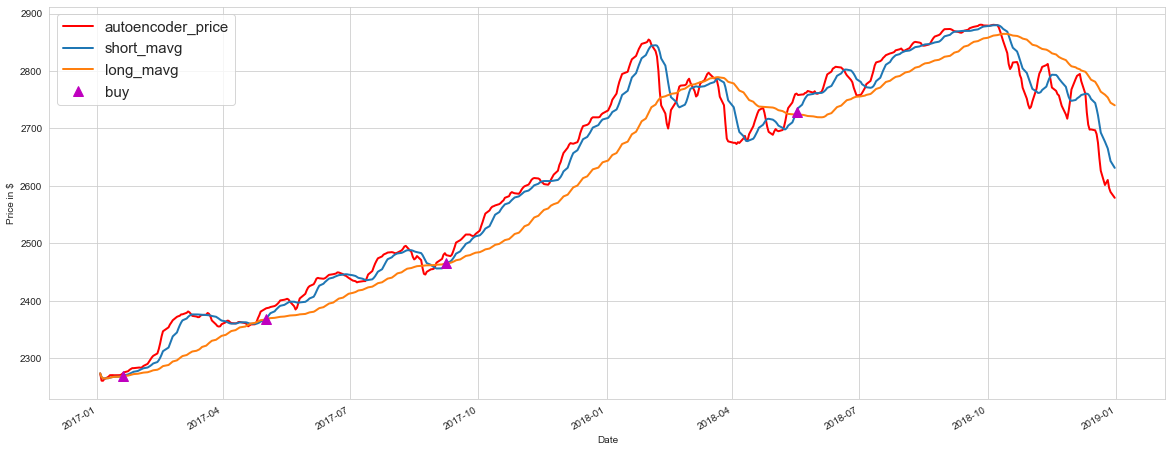

Date
2017-01-18    2271.889893
2017-04-28    2384.199951
2017-09-05    2457.850098
2018-03-16    2752.010010
2018-05-14    2730.129883
Name: original_price, dtype: float64
Date
2017-01-19    2263.689941
2017-05-02    2391.169922
2017-09-08    2461.429932
2018-05-17    2720.129883
Name: original_price, dtype: float64


In [45]:
### reconstructed ###############
short_window = 10
long_window = 50

signals = pd.DataFrame(index=df_encode.index)
signals['signal'] = 0.0
signals['short_mavg'] = df_encode['autoencoder_price'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = df_encode['autoencoder_price'].rolling(window=long_window, min_periods=1, center=False).mean()
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')
df_encode['autoencoder_price'].plot(ax=ax1, color='r', lw=2.)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m',label='buy')
         
# ax1.plot(signals.loc[signals.positions == -1.0].index, 
#          signals.short_mavg[signals.positions == -1.0],
#          'v', markersize=10, color='k',label='sell')
         
plt.legend(loc=2, prop={'size': 15})
plt.show()
print(df_original.original_price[trade_signals.trade_positions == 1.0])
print(df_original.original_price[signals.positions == 1.0])

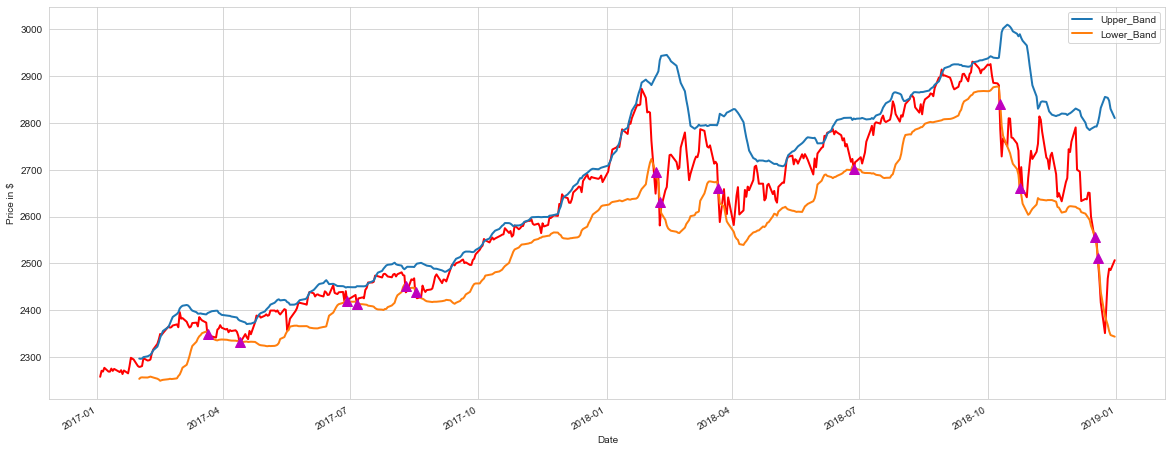

Date
2017-03-21    2344.020020
2017-04-13    2328.949951
2017-06-29    2419.699951
2017-07-06    2409.750000
2017-08-10    2438.209961
2017-08-17    2430.010010
2018-02-05    2648.939941
2018-02-08    2581.000000
2018-03-22    2643.689941
2018-06-27    2699.629883
2018-10-10    2785.679932
2018-10-24    2656.100098
2018-12-17    2545.939941
2018-12-19    2506.959961
Name: original_price, dtype: float64
Date
2017-03-24    2343.979980
2017-07-06    2409.750000
2017-08-22    2452.510010
2018-02-08    2581.000000
2018-03-26    2658.550049
2018-10-11    2728.370117
2018-12-20    2467.419922
Name: original_price, dtype: float64


In [46]:
### bb crossing
## original 

# Initialize the `signals` DataFrame with the `signal` column
bb_signals = pd.DataFrame(index=df_original.index)
bb_signals['bb_signal'] = 0.0


bb_signals['20 Day MA'] = df_original['original_price'].rolling(window=20).mean()
bb_signals['20 Day STD'] = df_original['original_price'].rolling(window=20).std()     
bb_signals['Upper_Band'] = bb_signals['20 Day MA'] + (bb_signals['20 Day STD'] * 2)
bb_signals['Lower_Band'] = bb_signals['20 Day MA'] - (bb_signals['20 Day STD'] * 2)


# Create signals
bb_signals['bb_signal'][20:] = np.where(bb_signals['Lower_Band'][20:] 
                                            > df_original['original_price'][20:], 1.0, 0.0)   

# Generate trading orders
bb_signals['bb_positions'] = bb_signals['bb_signal'].diff()
########################################################################################################
# Initialize the plot figure
fig = plt.figure()

# # Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# # Plot the closing price
df_original['original_price'].plot(ax=ax1, color='r', lw=2.)

# # Plot the short and long moving averages
bb_signals[['Upper_Band', 'Lower_Band']].plot(ax=ax1, lw=2.)

# # Plot the buy signals
ax1.plot(bb_signals.loc[bb_signals.bb_positions == 1.0].index, 
         bb_signals.Lower_Band[bb_signals.bb_positions == 1.0],
         '^', markersize=10, color='m')
         
# # Plot the sell signals
# ax1.plot(bb_signals.loc[bb_signals.bb_positions == -1.0].index, 
#          bb_signals.Upper_Band[bb_signals.bb_positions == -1.0],
#          'v', markersize=10, color='k')
         
plt.show()
print(df_original.original_price[bb_signals.bb_positions == 1.0])
print(df_original.original_price[bb_encode_signals.bb_encode_positions == 1.0])

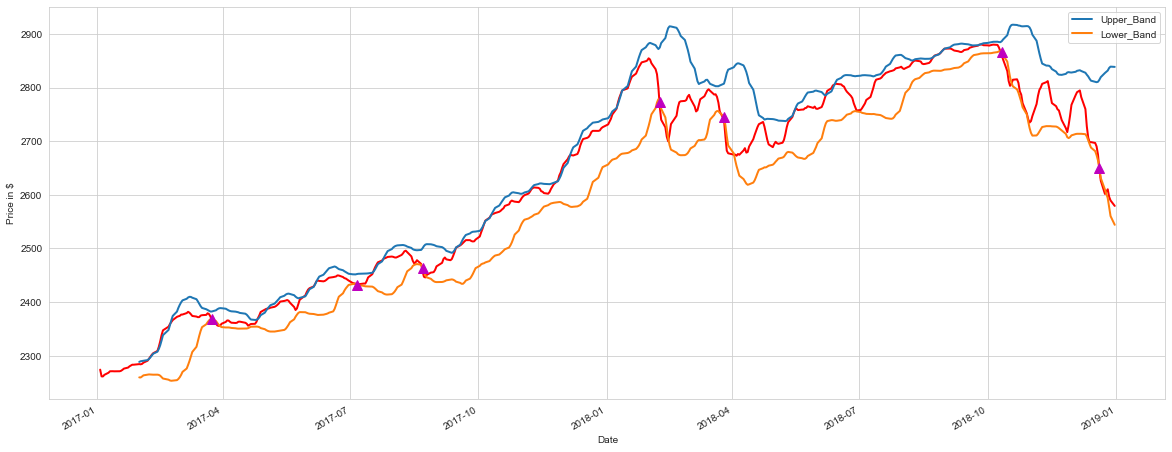

In [18]:
### reconstructed ###############

bb_encode_signals = pd.DataFrame(index=df_encode.index)
bb_encode_signals['bb_encode_signal'] = 0.0
bb_encode_signals['20 Day MA'] = df_encode['autoencoder_price'].rolling(window=20).mean()
bb_encode_signals['20 Day STD'] = df_encode['autoencoder_price'].rolling(window=20).std()     
bb_encode_signals['Upper_Band'] = bb_encode_signals['20 Day MA'] + (bb_encode_signals['20 Day STD'] * 2)
bb_encode_signals['Lower_Band'] = bb_encode_signals['20 Day MA'] - (bb_encode_signals['20 Day STD'] * 2)
bb_encode_signals['bb_encode_signal'][20:] = np.where(bb_encode_signals['Lower_Band'][20:] 
                                            > df_encode['autoencoder_price'][20:], 1.0, 0.0)   

bb_encode_signals['bb_encode_positions'] = bb_encode_signals['bb_encode_signal'].diff()

fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')

df_encode['autoencoder_price'].plot(ax=ax1, color='r', lw=2.)
bb_encode_signals[['Upper_Band', 'Lower_Band']].plot(ax=ax1, lw=2.)
ax1.plot(bb_encode_signals.loc[bb_encode_signals.bb_encode_positions == 1.0].index, 
         bb_encode_signals.Lower_Band[bb_encode_signals.bb_encode_positions == 1.0],
         '^', markersize=10, color='m')
         
# ax1.plot(bb_signals.loc[bb_signals.bb_positions == -1.0].index, 
#          bb_signals.Upper_Band[bb_signals.bb_positions == -1.0],
#          'v', markersize=10, color='k')
         
plt.show()


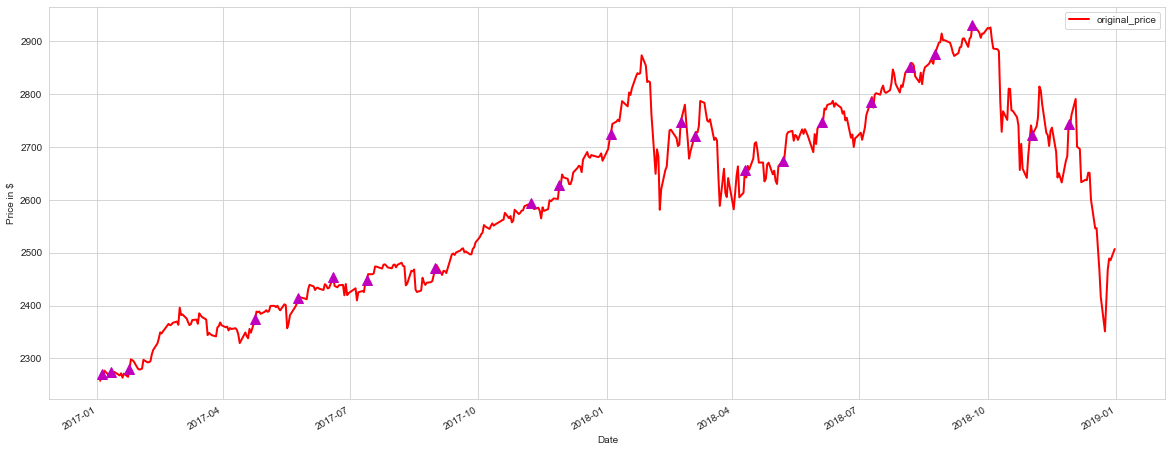

Date
2017-01-04    2270.750000
2017-01-11    2275.320068
2017-01-24    2280.070068
2017-04-24    2374.149902
2017-05-25    2415.070068
2017-06-19    2453.459961
2017-07-13    2447.830078
2017-08-31    2471.649902
2017-11-08    2594.379883
2017-11-28    2627.040039
2018-01-04    2723.989990
2018-02-23    2747.300049
2018-03-05    2720.939941
2018-04-10    2656.870117
2018-05-07    2672.629883
2018-06-04    2746.870117
2018-07-09    2784.169922
2018-08-06    2850.399902
2018-08-24    2874.689941
2018-09-20    2930.750000
2018-11-02    2723.060059
2018-11-28    2743.790039
Name: original_price, dtype: float64
Date
2017-01-09    2268.899902
2017-04-26    2387.449951
2017-05-31    2411.800049
2017-07-18    2460.610107
2017-09-06    2465.540039
2017-11-28    2627.040039
2018-01-05    2743.149902
2018-02-27    2744.280029
2018-04-16    2677.840088
2018-07-11    2774.020020
2018-08-28    2897.520020
2018-11-07    2813.889893
2018-11-30    2760.169922
Name: original_price, dtype: float64


In [47]:
########### macd#########################
from stockstats import StockDataFrame as Sdf
# original
x_original= pd.DataFrame(X_inverse,columns=['close'],index=df.index)
stock_original  = Sdf.retype(x_original)

signal_macd_original = stock_original['macds']        # signal line
macd_original  = stock_original['macd']         # The MACD that need to cross the signal line
listLongShort = ["No data"]    

for i in range(1, len(signal_macd_original)):
    if macd_original[i] > signal_macd_original[i] and macd_original[i - 1] <= signal_macd_original[i - 1]:
        listLongShort.append(1.0)
    elif macd_original[i] < signal_macd_original[i] and macd_original[i - 1] >= signal_macd_original[i - 1]:
        listLongShort.append(-1.0)
    else:
        listLongShort.append(0.0)

stock_original['Advice'] = listLongShort

fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')
df_original[['original_price']].plot(ax=ax1, color='r', lw=2.)

ax1.plot(stock_original.loc[stock_original.Advice == 1.0].index, 
         stock_original.close[stock_original.Advice == 1.0],
         '^', markersize=10, color='m')
plt.show()
print(df_original.original_price[stock_original.Advice == 1.0])
print(df_original.original_price[stock_new.Advice_NEW == 1.0])

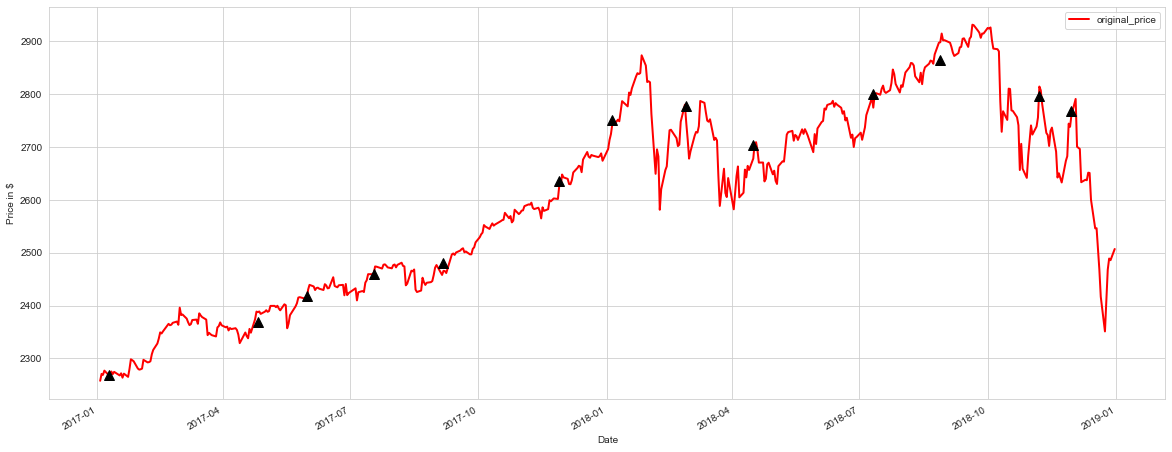

In [20]:
##### reconstructed #####################
df_encode_new = pd.DataFrame(e_inverse,columns=['close'],index=df.index)
stock_new  = Sdf.retype(df_encode_new)

signal_macd = stock_new['macds'] 
macd  = stock_new['macd']         
listLongShort = ["No data"]

for i in range(1, len(signal_macd)):
    if macd[i] > signal_macd[i] and macd[i - 1] <= signal_macd[i - 1]:
        listLongShort.append(1.0)
    elif macd[i] < signal_macd[i] and macd[i - 1] >= signal_macd[i - 1]:
        listLongShort.append(-1.0)
    else:
        listLongShort.append(0.0)

stock_new['Advice_NEW'] = listLongShort

fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')

df_original[['original_price']].plot(ax=ax1, color='r', lw=2.)      
ax1.plot(stock_new.loc[stock_new.Advice_NEW == 1.0].index, 
         stock_new.close[stock_new.Advice_NEW == 1.0],
         '^', markersize=10, color='k')

# ax1.plot(stock.loc[stock.Advice == 1.0].index, 
#          stock.close[stock.Advice == 1.0],
#          '^', markersize=10, color='k')
plt.show()

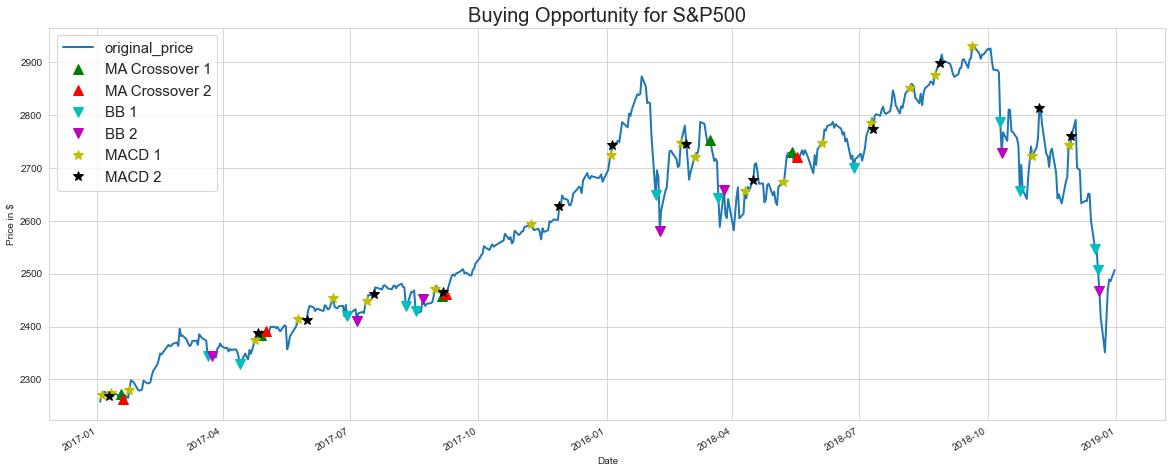

In [21]:
#####################################################
############# all in one ############################
#####################################################

fig = plt.figure()

ax1 = fig.add_subplot(111,  ylabel='Price in $')
df_original[['original_price']].plot(ax=ax1, lw=2.)

## ma
ax1.plot(trade_signals.loc[trade_signals.trade_positions == 1.0].index, 
         df_original.original_price[trade_signals.trade_positions == 1.0],
         '^', markersize=10, color='g',label='MA Crossover 1')
         
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         df_original.original_price[signals.positions == 1.0],
         '^', markersize=10, color='r',label='MA Crossover 2')


## bb
ax1.plot(bb_signals.loc[bb_signals.bb_positions == 1.0].index, 
         df_original.original_price[bb_signals.bb_positions == 1.0],
         'v', markersize=10, color='c',label='BB 1')

ax1.plot(bb_encode_signals.loc[bb_encode_signals.bb_encode_positions == 1.0].index, 
         df_original.original_price[bb_encode_signals.bb_encode_positions == 1.0],
         'v', markersize=10, color='m',label='BB 2')



## macd
ax1.plot(stock_original.loc[stock_original.Advice == 1.0].index, 
         df_original.original_price[stock_original.Advice == 1.0],
         '*', markersize=10, color='y',label='MACD 1')

ax1.plot(stock_new.loc[stock_new.Advice_NEW == 1.0].index, 
         df_original.original_price[stock_new.Advice_NEW == 1.0],
         '*', markersize=10, color='k',label='MACD 2')


plt.title('Buying Opportunity for S&P500',fontsize=20)
plt.legend(loc=2, prop={'size': 15})
plt.show()